In [1]:
import pandas_datareader.data as web
import numpy as np

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as finance

from scipy import stats

In [2]:
sber = finance.download('SBER.ME', start='2006-01-01', end="2021-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
#nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()
nasdaq = sber["Open"].squeeze().dropna()

In [5]:
nasdaq = nasdaq.asfreq('M')
for i in reversed(range(nasdaq.shape[0])):
    if nasdaq[i].astype(str) == 'nan':
        nasdaq[i] = nasdaq[i+1]

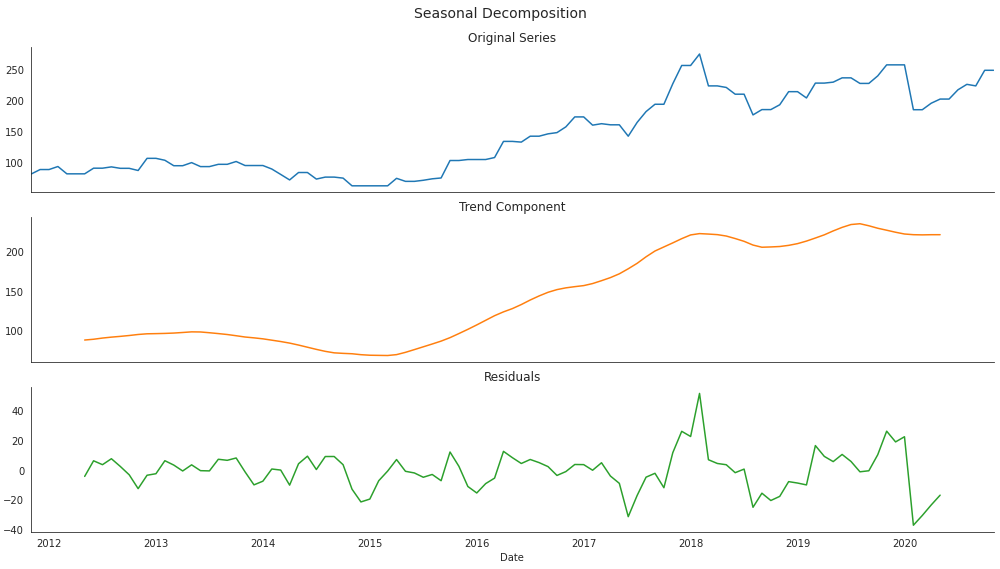

In [6]:
components = tsa.seasonal_decompose(nasdaq, model='additive')

ts = (nasdaq.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

In [7]:
ts = (nasdaq.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Residual=components.resid))
ts = ts.dropna()
working = ts["Trend"]

In [8]:
def random_walking(discrete_steps, continuous_steps, increment):
    dt = 1 * continuous_steps / discrete_steps
    random_increment = np.random.normal(.0, 1.0 * increment, discrete_steps) * np.sqrt(dt)
    motion = np.cumsum(random_increment)
    motion = np.insert(motion, 0 , 0.0)
    return motion, random_increment

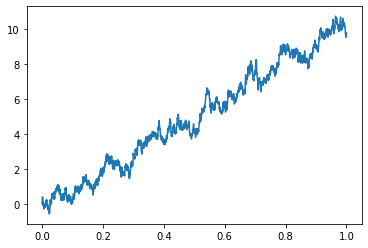

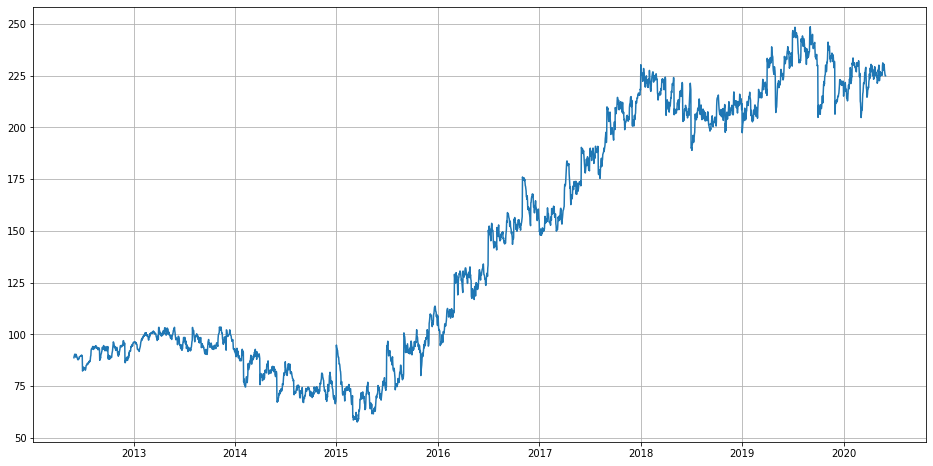

In [9]:
def random_walking(discrete_steps, continuous_steps, increment):
    dt = 1 * continuous_steps / discrete_steps
    random_increment = np.random.normal(.0, 5 * increment, discrete_steps) * np.sqrt(dt)
    motion = np.cumsum(random_increment)
    motion = np.insert(motion, 0 , 0.0)
    return motion, random_increment

working = ts["Trend"]
working = working.asfreq('d')
i = working.shape[0] - 1
y, epsilon = random_walking((i), 1 ,1)
y = y
tr = np.linspace(0.0, 1, (i) + 1)
plt.plot(tr, y)
plt.show()

for i in reversed(range(working.shape[0])):
    if working[i].astype(str) == 'nan':
        working[i] = working[i+1]
    normal = stats.norm(working[i], abs(y[i]) ** (1/3))
    working[i] = normal.rvs()

plt.figure(figsize=(16,8))
plt.grid()
plt.plot(working)
plt.show()

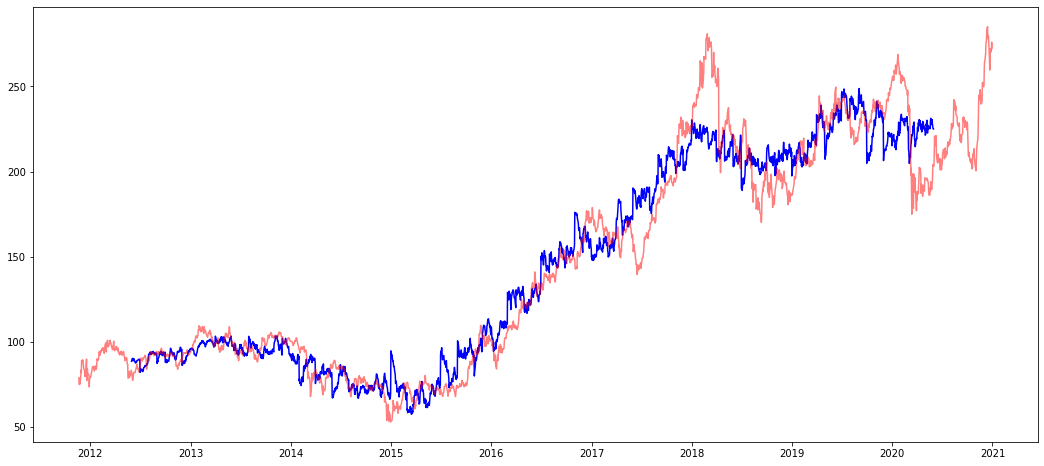

In [10]:
plt.figure(figsize=(18,8))

plt.plot(working, color='blue')
plt.plot(sber["Open"], color='red', alpha=.5)

[*********************100%***********************]  1 of 1 completed


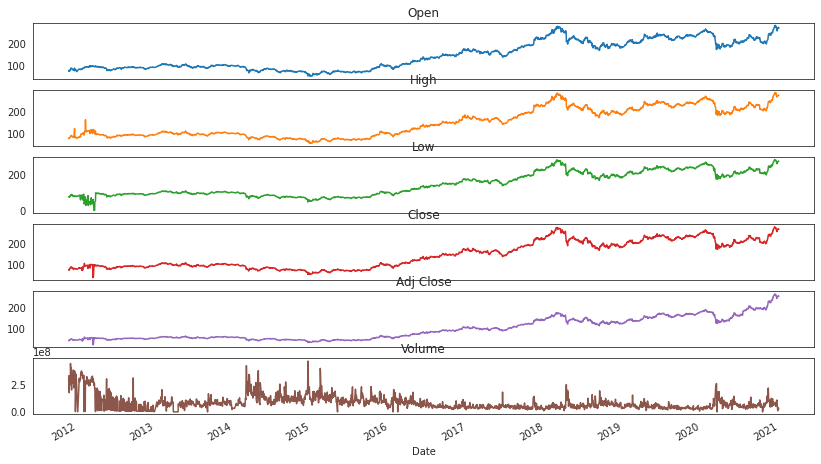

In [11]:
working[:1000]


sber = finance.download('SBER.ME', start='2006-01-01', end="2021-01-01")
with sns.axes_style('white'):
    sber.plot(subplots=True, figsize=(14, 8), title=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], legend=False)


sber_pre = sber["Close"].pct_change().dropna()
mu = sber_pre.mean()
sigma = sber_pre.std()

<Figure size 720x576 with 0 Axes>

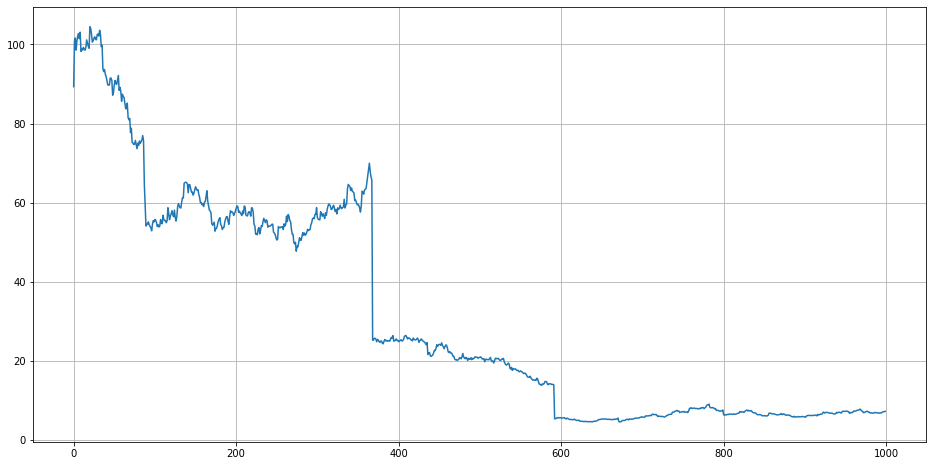

In [12]:
plt.figure(figsize=(10,8))
start_price = ts["Trend"][0]
a, b = list(), list()
for i in range(1000):
    start_price *= (1 + np.random.choice(sber_pre))
    a.append(i)
    b.append(start_price)

plt.figure(figsize=(16,8))
plt.grid()
plt.plot(a, b)


plt.show()

In [13]:
compile = (working[:1000] * np.log(np.array(b)))

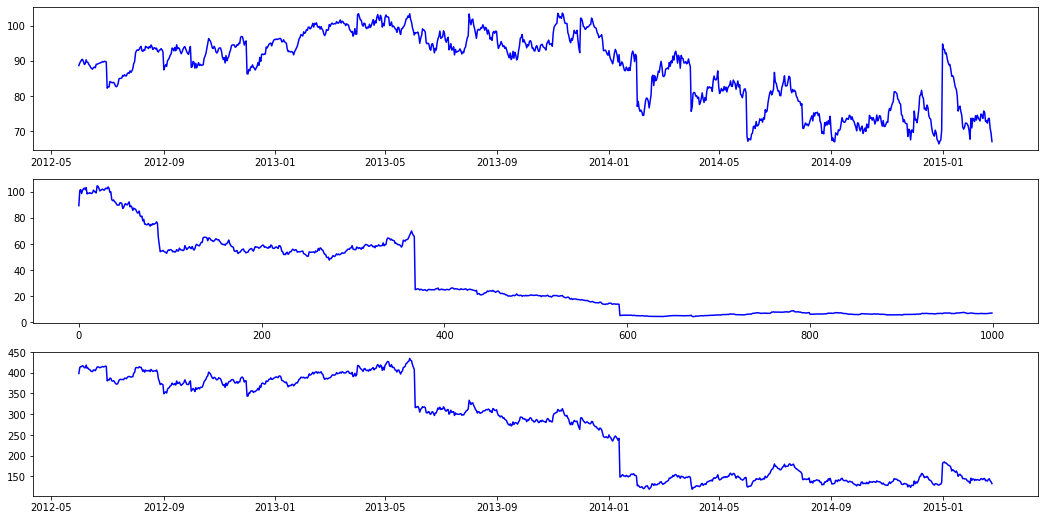

In [14]:
plt.figure(figsize=(18, 9))
plt.subplot(3,1,1)
plt.plot(working[:1000], color='blue')
plt.subplot(3,1,2)
plt.plot(b, color='blue')
plt.subplot(3,1,3)
plt.plot(compile, color='blue')
plt.show()

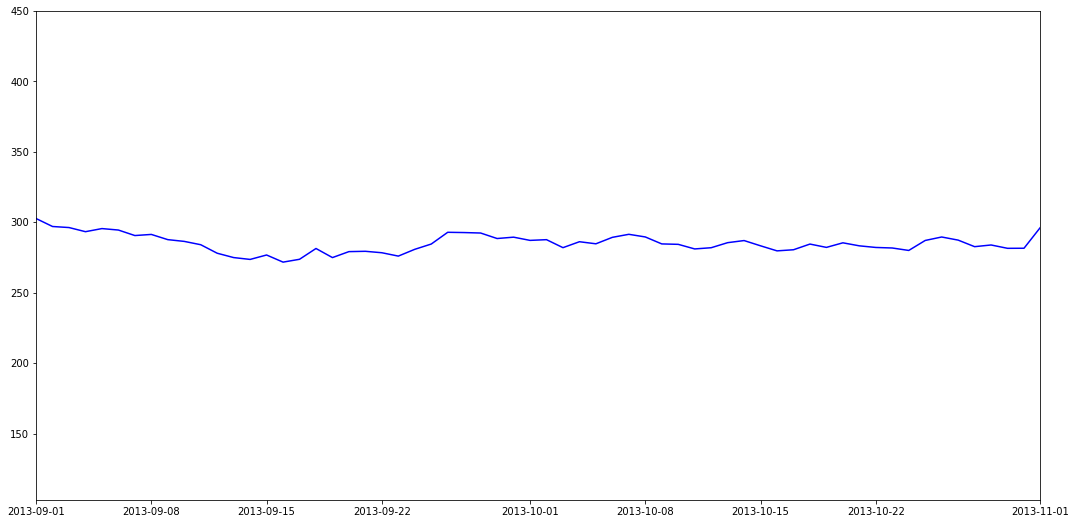

In [15]:
import datetime
plt.figure(figsize=(18, 9))
plt.xlim(datetime.date(2013, 9, 1), datetime.date(2013, 11, 1))
plt.plot(compile, color='blue')
plt.show()

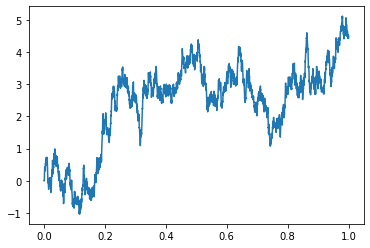

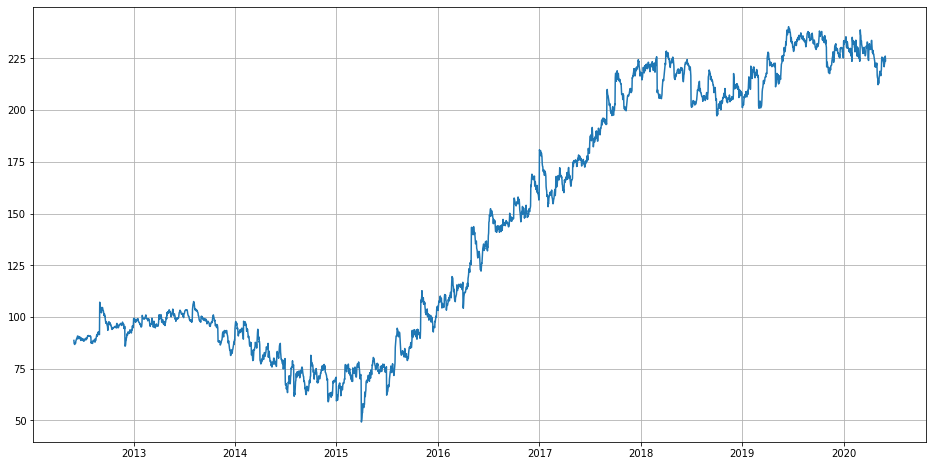

[*********************100%***********************]  1 of 1 completed


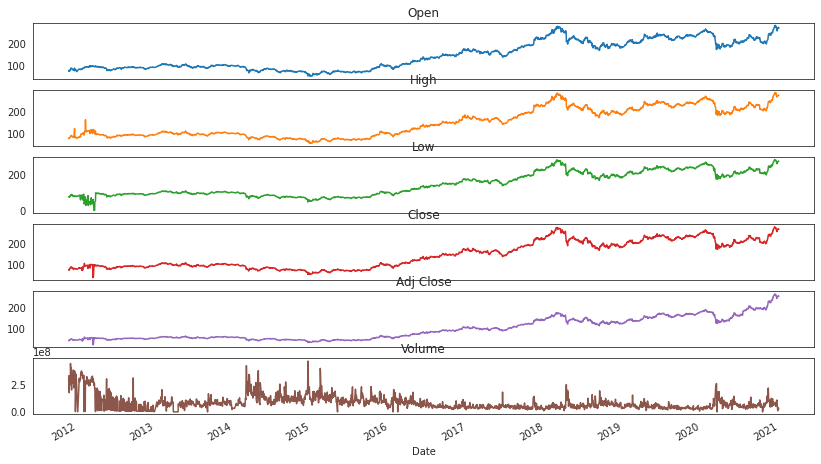

<Figure size 720x576 with 0 Axes>

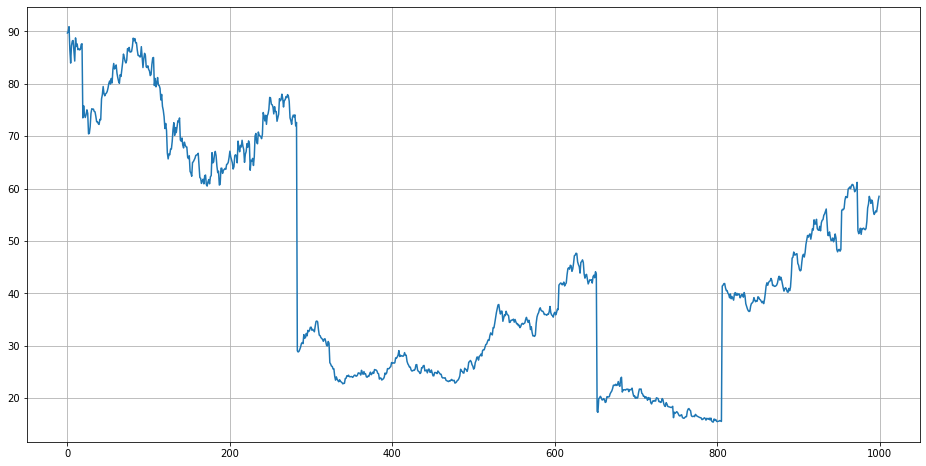

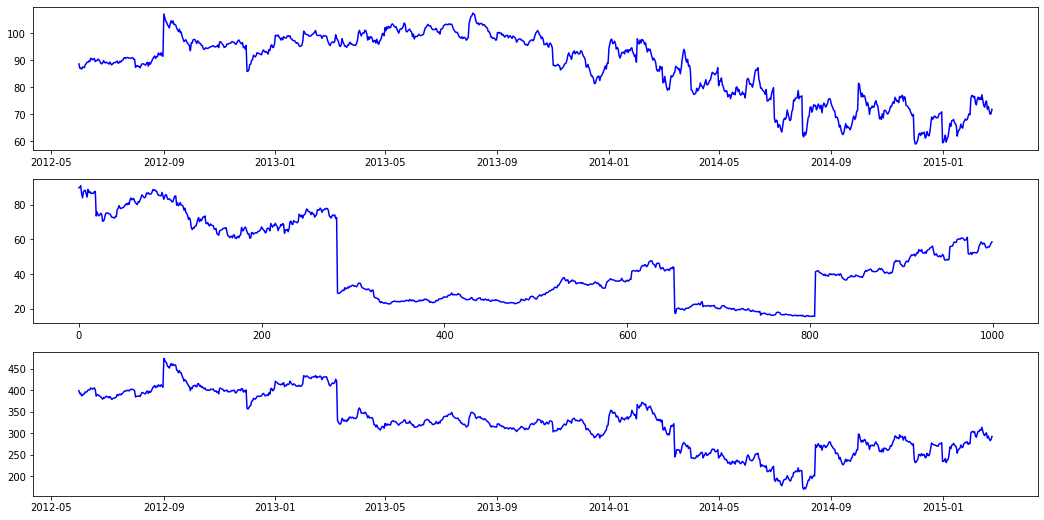

In [17]:

def generation():

    def random_walking(discrete_steps, continuous_steps, increment):
        dt = 1 * continuous_steps / discrete_steps
        random_increment = np.random.normal(.0, 5 * increment, discrete_steps) * np.sqrt(dt)
        motion = np.cumsum(random_increment)
        motion = np.insert(motion, 0 , 0.0)
        return motion, random_increment

    working = ts["Trend"]
    working = working.asfreq('d')
    i = working.shape[0] - 1
    y, epsilon = random_walking((i), 1 ,1)
    y = y
    tr = np.linspace(0.0, 1, (i) + 1)
    plt.plot(tr, y)
    plt.show()

    for i in reversed(range(working.shape[0])):
        if working[i].astype(str) == 'nan':
            working[i] = working[i+1]
        normal = stats.norm(working[i], abs(y[i]) ** (1/3))
        working[i] = normal.rvs()

    plt.figure(figsize=(16,8))
    plt.grid()
    plt.plot(working)
    plt.show()
    sber = finance.download('SBER.ME', start='2006-01-01', end="2021-01-01")
    with sns.axes_style('white'):
        sber.plot(subplots=True, figsize=(14, 8), title=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], legend=False)


    sber_pre = sber["Close"].pct_change().dropna()
    mu = sber_pre.mean()
    sigma = sber_pre.std()

    plt.figure(figsize=(10,8))
    start_price = ts["Trend"][0]
    a, b = list(), list()
    for i in range(1000):
        start_price *= (1 + np.random.choice(sber_pre))
        a.append(i)
        b.append(start_price)

    plt.figure(figsize=(16,8))
    plt.grid()
    plt.plot(a, b)


    plt.show()
    compile = (working[:1000] * np.log(np.array(b)))

    plt.figure(figsize=(18, 9))
    plt.subplot(3,1,1)
    plt.plot(working[:1000], color='blue')
    plt.subplot(3,1,2)
    plt.plot(b, color='blue')
    plt.subplot(3,1,3)
    plt.plot(compile, color='blue')
    plt.show()



generation()